In [1]:
import sys
sys.path.append("../../../xapres/")
import xapres as xa
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math
import os 
import xrft
from numpy import allclose as npc

## three versions of the processing

I am going to do the fft processing three times: 
1. using the code used in xapres currently (which came from Keith)
2. using numpy
3. using xarray as much as possible

I will check these are all the same. 

I will implement the third option in xapres.utils

# Constants and load the data

In [50]:
T = 1               # chirp duration [s]
f_1 = 200e6         # starting frequency [Hz]
f_2 = 400e6         # ending frequency [Hz]
B = f_2 - f_1       # bandwidth [Hz]
K = B/T             # rate of chnge of frequency [Hz/s]
c = 300000000.0     # speed of lightin a vacuum [m/s]
ep = 3.18           # permittivity of ice
f_c = (f_2+f_1)/2   # center frequency [Hz]

fd = xa.load.from_dats(max_range=2500)
root_directory = 'gs://ldeo-glaciology/apres/thwaites'
filenames = fd.list_files(directory = root_directory, remote_load=True)
directory = os.path.dirname(filenames[20])
ds = fd.load_all(directory = directory, remote_load=True, file_numbers_to_process=[0])    # this loads the data and performs the fft 

In [176]:
ds = fd.load_all(directory = 'gs://ldeo-glaciology/apres/thwaites/2022-2023/Point/G1-25-05', remote_load=True, file_numbers_to_process=[0]) 

In [177]:
ds

<xarray.Dataset> Size: 51MB
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-20...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 26.0
    orientation      (time) <U7 28B 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 32MB ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 19MB ...
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.2296
    temperature_1    (time) float64 8B 505.5
    temperature_2    (time) float64 8B 505.0
Attributes:
    processing:  Created on 2024-10-09 13:14:59.648917

In [131]:
ds_one = ds.isel(chirp_num = 0, attenuator_setting_pair = 0)
chirp_da = ds.chirp
chirp_np = chirp_da.isel(chirp_num = 0, attenuator_setting_pair = 0).values.squeeze()
chirp_da_one = chirp_da.isel(chirp_num = 0, attenuator_setting_pair = 0)

In [3]:
def dB(S):
    return 20*np.log10(np.abs(S))

In [4]:
pad_factor = 2

# 1. as originally implemented in xapres (from Keith N)

In [9]:
# get lengths to make the data
Nt_1 = len(chirp_np)
Nt_1 = math.floor(Nt_1/2) * 2
Nfft = math.floor(Nt_1*pad_factor)
print(Nt_1, Nfft)

40000 80000


In [10]:
# window
s_w_1 = np.multiply(chirp_np[0:Nt_1], np.blackman(Nt_1))

# pad and roll
s_wpr_1 = np.zeros(Nfft)
s_wpr_1[0:math.floor(Nt_1/2)] = s_w_1[math.floor(Nt_1/2):]
s_wpr_1[-math.floor(Nt_1/2):] = s_w_1[0:math.floor(Nt_1/2)]

In [11]:
## fft
S_wpr_1 = np.fft.fft(s_wpr_1)/Nfft * np.sqrt(2*pad_factor) 

In [12]:
# range
bin2m1 = c/(2*pad_factor*np.sqrt(ep)*K)
profile_range_1 = np.arange(Nfft) * bin2m1

In [13]:
## reference array
m = np.arange(len(S_wpr_1))/pad_factor
phiref = 2*np.pi*f_c*m/B -  m * m * 2*np.pi * K/2/B**2
S_wprr_1 = S_wpr_1 * np.exp(phiref*(-1j))

In [14]:
# is it the same as what we processed using xapres before?
cropped_N = len(ds_one.profile_range)

# no, its isnt, because there is a slight error in the padding step in xapres (see this issue for more details https://github.com/ldeo-glaciology/xapres/issues/48)) 
npc(ds_one.profile.values.squeeze(), S_wprr_1[:cropped_N])

False

In [15]:
# to get the profile computed here to agree with the profile computed in xapres, we need to change the padding step above as follows
s_wpr_xapres = np.zeros(Nfft)
s_wpr_xapres[0:math.floor(Nt_1/2)-1] = s_w_1[math.floor(Nt_1/2):-1]
s_wpr_xapres[-math.floor(Nt_1/2):-1] = s_w_1[0:math.floor(Nt_1/2)-1]

# and redo the fft and ref array
S_wpr_xapres = np.fft.fft(s_wpr_xapres)/Nfft * np.sqrt(2*pad_factor) 

S_wprr_xapres = S_wpr_xapres * np.exp(phiref*(-1j))

npc(ds_one.profile.values.squeeze(), S_wprr_xapres[:cropped_N])

True

From this we can conclude that the above is an accurate representation of the xapres code, except that it corrects the error in the padding described in this[issue](https://github.com/ldeo-glaciology/xapres/issues/48).

Below we will compare the numpy and xarray versions to the corrected version above. 


## 2. using numpy

In [16]:
# get the lengths to make the data

def rdi(x):
    """round down to the nearest integer and return an integer"""
    return int(np.floor(x))
def rdei(x):
    """round down to the nearest even integer and return an integer"""
    return int(np.floor(x/2) * 2)

t = chirp_da.chirp_time.values
Nt_2 = rdei(len(chirp_np))  
chirp_np = chirp_np[:Nt_2]
t = t[:Nt_2]

In [19]:
# window
s_w_2 = chirp_np * np.blackman(Nt_2)

# pad
s_wp_2 = np.pad(s_w_2, pad_width=int((Nt_2*pad_factor-Nt_2)/2))

# roll
s_wpr_2 = np.roll(s_wp_2, shift = int(Nt_2*pad_factor/2))

(s_wpr_2 == s_wpr_1).all()

np.True_

In [20]:
# fft
dt = chirp_da.chirp_time.values[1] - chirp_da.chirp_time.values[0]
sampling_frequency = 1/dt   # [Hz]

def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s, axis=0)/no_of_samples * np.sqrt(2*pad_factor)        
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies

S_wpr_2, frequencies = fft(s_wpr_2)

(S_wpr_1 == S_wpr_2).all()

np.True_

In [21]:
# range
def range(frequencies):
    return c * frequencies / (2*np.sqrt(ep)*K)

profile_range_2 = range(frequencies)
npc(profile_range_1, profile_range_2)

True

In [22]:
# reference array
m = np.arange(len(S_wpr_2))/pad_factor
phiref = 2*np.pi*f_c*m/B -  m * m * 2*np.pi * K/2/B**2
S_wprr_2 = S_wpr_2 * np.exp(phiref*(-1j))
npc(S_wprr_1, S_wprr_2)

True

## 3. using xarray 
(now works for a dataarray with lots of additional dimensions)

In [52]:
# get the lengths to make the data
Nt_3 = rdei(chirp_da.chirp_time.size)   # add a -2 here to see the effect on one of the fft methods below and not all of them. 
chirp_da2 = chirp_da.isel(chirp_time = slice(0, Nt_3))

In [53]:
# window
filter = xr.DataArray(np.blackman(Nt_3), dims = 'chirp_time')
s_w_3 = chirp_da2 * filter
#assert (s_w_3 == s_w_2).all()
assert (s_w_3.isel(chirp_num=0, attenuator_setting_pair=0).values.squeeze() == s_w_2).all()


In [54]:
# pad
s_wp_3 = s_w_3.pad(chirp_time=int((Nt_2*pad_factor-Nt_2)/2), constant_values=0)
assert (s_wp_3.isel(chirp_num=0, attenuator_setting_pair=0).values.squeeze() == s_wp_2).all()   # we get the values right, but we should ignore chirp_time now becuase it is padded with nans


In [55]:
# roll
s_wpr_3 = s_wp_3.roll(chirp_time=int(Nt_2*pad_factor/2))  
#assert (s_wpr_3 == s_wpr_2).all()
assert (s_wpr_3.isel(chirp_num=0, attenuator_setting_pair=0).values.squeeze() == s_wpr_2).all()


In [172]:
# fft
S_wpr_3 = xr.apply_ufunc(np.fft.fft, 
                        s_wpr_3,
                        input_core_dims=[["chirp_time"]],
                        output_core_dims=[["chirp_time"]])
S_wpr_3 = S_wpr_3/s_wpr_3.chirp_time.size * np.sqrt(2*pad_factor) 

assert (S_wpr_3.isel(chirp_num=0, attenuator_setting_pair=0).values.squeeze() == S_wpr_2).all()
S_wpr_3

<xarray.DataArray (time: 1, chirp_num: 100, attenuator_setting_pair: 1,
                   chirp_time: 80000)> Size: 128MB
array([[[[0.00806367+0.00000000e+00j, 0.00710319-1.52129172e-06j,
          0.00479212+2.25160400e-07j, ..., 0.00236139-3.76569679e-06j,
          0.00479212-2.25160400e-07j, 0.00710319+1.52129172e-06j]],

        [[0.00807701+0.00000000e+00j, 0.00711427+5.72724051e-07j,
          0.00479838+2.39365643e-06j, ..., 0.00236376-4.59944573e-06j,
          0.00479838-2.39365643e-06j, 0.00711427-5.72724051e-07j]],

        [[0.00808097+0.00000000e+00j, 0.00711789+9.85494757e-07j,
          0.00480116+2.95825439e-06j, ..., 0.00236559-5.01985509e-06j,
          0.00480116-2.95825439e-06j, 0.00711789-9.85494757e-07j]],

        ...,

        [[0.00787558+0.00000000e+00j, 0.00693704+1.47459382e-07j,
          0.00467936+1.61813568e-06j, ..., 0.00230596-3.58599455e-06j,
          0.00467936-1.61813568e-06j, 0.00693704-1.47459382e-07j]],

        [[0.00787383+0.00000000e+00j, 0.00693542+2.66183799e-08j,
          0.00467799+1.57824652e-06j, ..., 0.00230475-3.85706465e-06j,
          0.00467799-1.57824652e-06j, 0.00693542-2.66183799e-08j]],

        [[0.00787246+0.00000000e+00j, 0.00693435-4.27478532e-07j,
          0.00467768+6.57967392e-07j, ..., 0.00230531-2.52560526e-06j,
          0.00467768-6.57967392e-07j, 0.00693435+4.27478532e-07j]]]])
Coordinates:
  * time          (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_time    (chirp_time) float64 640kB nan nan nan nan ... nan nan nan nan
  * chirp_num     (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
    filename      (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-2023/...
    burst_number  (time) int64 8B 0
    AFGain        (attenuator_setting_pair) int64 8B -4
    attenuator    (attenuator_setting_pair) float64 8B 26.0
    orientation   (time) <U7 28B 'unknown'
Dimensions without coordinates: attenuator_setting_pair

In [58]:
# range
indexes      = np.arange(s_wpr_3.chirp_time.size) 
frequencies  = indexes * sampling_frequency/s_wpr_3.chirp_time.size
profile_range_3 = range(frequencies)
assert np.allclose(profile_range_3, profile_range_1)

In [59]:
# reference array
m = np.arange(len(S_wpr_3.chirp_time))/pad_factor
phiref = 2*np.pi*f_c*m/B -  m * m * 2*np.pi * K/2/B**2
S_wprr_3 = S_wpr_3 * np.exp(phiref*(-1j))
npc(S_wprr_1, S_wprr_3.values)

False

In [60]:
S_wpr_3 = S_wpr_3.rename({'chirp_time': 'profile_range'})
S_wpr_3['profile_range'] = profile_range_3
S_wpr_3

<xarray.DataArray (time: 1, chirp_num: 100, attenuator_setting_pair: 1,
                   profile_range: 80000)> Size: 128MB
array([[[[0.00806367+0.00000000e+00j, 0.00710319-1.52129172e-06j,
          0.00479212+2.25160400e-07j, ..., 0.00236139-3.76569679e-06j,
          0.00479212-2.25160400e-07j, 0.00710319+1.52129172e-06j]],

        [[0.00807701+0.00000000e+00j, 0.00711427+5.72724051e-07j,
          0.00479838+2.39365643e-06j, ..., 0.00236376-4.59944573e-06j,
          0.00479838-2.39365643e-06j, 0.00711427-5.72724051e-07j]],

        [[0.00808097+0.00000000e+00j, 0.00711789+9.85494757e-07j,
          0.00480116+2.95825439e-06j, ..., 0.00236559-5.01985509e-06j,
          0.00480116-2.95825439e-06j, 0.00711789-9.85494757e-07j]],

        ...,

        [[0.00787558+0.00000000e+00j, 0.00693704+1.47459382e-07j,
          0.00467936+1.61813568e-06j, ..., 0.00230596-3.58599455e-06j,
          0.00467936-1.61813568e-06j, 0.00693704-1.47459382e-07j]],

        [[0.00787383+0.00000000e+00j, 0.00693542+2.66183799e-08j,
          0.00467799+1.57824652e-06j, ..., 0.00230475-3.85706465e-06j,
          0.00467799-1.57824652e-06j, 0.00693542-2.66183799e-08j]],

        [[0.00787246+0.00000000e+00j, 0.00693435-4.27478532e-07j,
          0.00467768+6.57967392e-07j, ..., 0.00230531-2.52560526e-06j,
          0.00467768-6.57967392e-07j, 0.00693435+4.27478532e-07j]]]])
Coordinates:
  * time           (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_num      (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
    filename       (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-2023...
    burst_number   (time) int64 8B 0
    AFGain         (attenuator_setting_pair) int64 8B -4
    attenuator     (attenuator_setting_pair) float64 8B 26.0
    orientation    (time) <U7 28B 'unknown'
  * profile_range  (profile_range) float64 640kB 0.0 0.2103 ... 1.682e+04
Dimensions without coordinates: attenuator_setting_pair

## Make the code above (in section 3 above) into a function

In [124]:
def FormProfile(chirps, 
                pad_factor = 2, 
                drop_noisy_chirps = True,
                clip_threshold = 1.2,
                min_chirps = 20,
                demean = True,
                detrend = True,
                stack = False,
                crop_chirp_start = None,
                crop_chirp_end = None,
                max_range = None,
                ):

    def rdei(x):
        """round down to the nearest even integer and return an integerr"""
        return int(np.floor(x/2) * 2)

    def freq2range(frequencies):
        """"return the range for a given frequency"""
        return c * frequencies / (2*np.sqrt(ep)*K)

    if (crop_chirp_start is not None) ^ (crop_chirp_end is not None):   # xor operation (only one of them is True)
        raise ValueError("If either of crop_chirp_start or crop_chirp_end is supplied, the other must also be supplied.")

    dt = chirps.chirp_time.values[1] - chirps.chirp_time.values[0]
    sampling_frequency = 1/dt 

    if crop_chirp_start is not None:
        chirps = chirps.sel(chirp_time = slice(crop_chirp_start, crop_chirp_end))

    if drop_noisy_chirps:
        bad_chirps =  chirps.where(abs(chirps) > clip_threshold)
        good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
        chirps = chirps.where(good_bursts)
        chirps = chirps.where(abs(chirps).max(dim='chirp_time')<clip_threshold)

    if demean:
        chirps = chirps - chirps.mean(dim='chirp_time')

    if detrend:
        p = chirps.polyfit('chirp_time', 1)
        fit = xr.polyval(chirps.chirp_time, p.polyfit_coefficients)
        chirps = chirps - fit

    if stack:   
        chirps = chirps.mean(dim='chirp_num', skipna=True)


    Nt_3 = rdei(chirps.chirp_time.size)   # add a -2 here to see the effect on one of the fft methods below and not all of them. 
    s = chirps.isel(chirp_time = slice(0, Nt_3))

    # window
    filter = xr.DataArray(np.blackman(Nt_3), dims = 'chirp_time')
    s_w_3 = s * filter
    
    # pad
    s_wp_3 = s_w_3.pad(chirp_time=int((Nt_3*pad_factor-Nt_3)/2), constant_values=0)

    # roll
    s_wpr_3 = s_wp_3.roll(chirp_time=int(Nt_3*pad_factor/2))  

    # fft
    S_wpr_3 = xr.apply_ufunc(np.fft.fft, 
                        s_wpr_3,
                        input_core_dims=[["chirp_time"]],
                        output_core_dims=[["chirp_time"]])
    S_wpr_3 = S_wpr_3/s_wpr_3.chirp_time.size * np.sqrt(2*pad_factor) 

    # range
    indexes      = np.arange(s_wpr_3.chirp_time.size) 
    frequencies  = indexes * sampling_frequency/s_wpr_3.chirp_time.size
    profile_range_3 = freq2range(frequencies)

    # reference array
    m = np.arange(len(S_wpr_3.chirp_time))/pad_factor
    phiref = 2*np.pi*f_c*m/B -  m * m * 2*np.pi * K/2/B**2
    S_wprr_3 = S_wpr_3 * np.exp(phiref*(-1j))
    S_wprr_3 = S_wprr_3.rename('profile')
    S_wprr_3 = S_wprr_3.rename({'chirp_time': 'profile_range'})
    S_wprr_3['profile_range'] = profile_range_3

    if max_range is not None:
        S_wprr_3 = S_wprr_3.where(S_wprr_3.profile_range <= max_range, drop=True)
    
    return S_wprr_3

In [125]:
S = FormProfile(chirp_da, pad_factor = 2, demean=False, detrend = False, stack = False, drop_noisy_chirps = False)
npc(S_wprr_3.values, S.values)

True

(0.0, 2500.0)

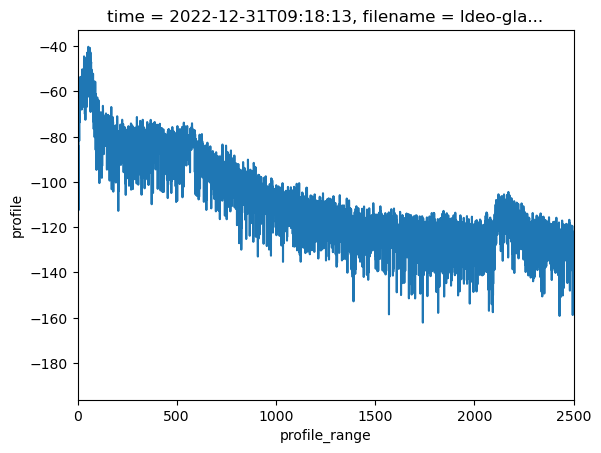

In [126]:
S = FormProfile(chirp_da, pad_factor = 4, demean=True, detrend = True, stack = True, drop_noisy_chirps = True)
S.isel(attenuator_setting_pair=0).dB().plot()
plt.xlim(0, 2500)

(0.0, 100.0)

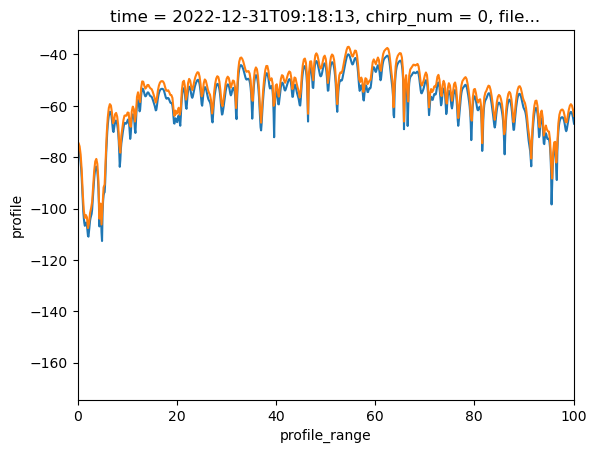

In [127]:
FormProfile(chirp_da, pad_factor = 4).isel(chirp_num=0, attenuator_setting_pair=0).dB().plot()
FormProfile(chirp_da, pad_factor = 2).isel(chirp_num=0, attenuator_setting_pair=0).dB().plot()
plt.xlim(0, 100)


(0.0, 2500.0)

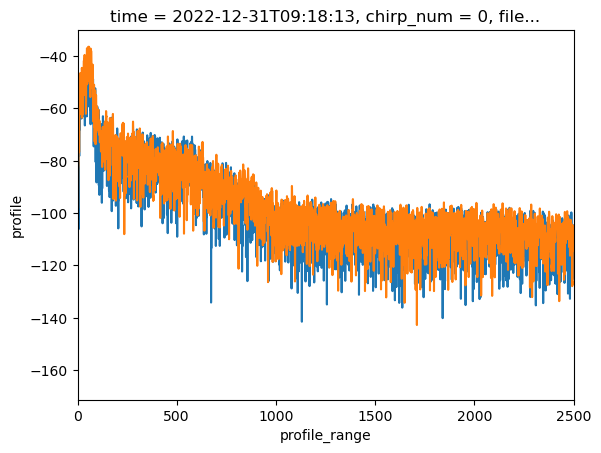

In [128]:
FormProfile(chirp_da.sel(chirp_time = slice(0, 1))).isel(chirp_num=0, attenuator_setting_pair=0).dB().plot()
FormProfile(chirp_da.sel(chirp_time = slice(0.5, 1))).isel(chirp_num=0, attenuator_setting_pair=0).dB().plot()

plt.xlim(0, 2500)

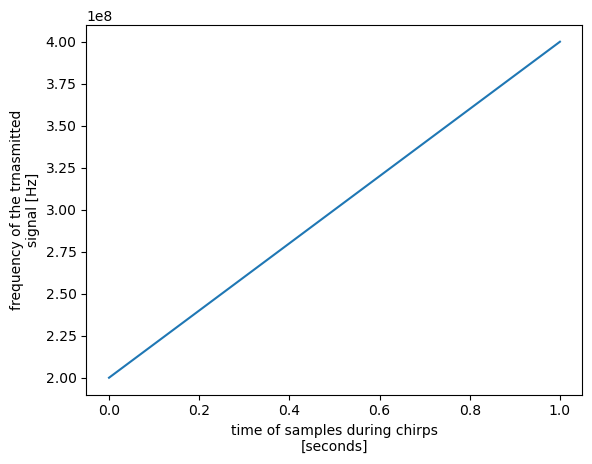

In [129]:
# add frequency to the dataarray
f_1 = 200e6
f_2 = 400e6

f = chirp_da.chirp_time.values * K + f_1

chirp_da = chirp_da.assign_coords(frequency=("chirp_time", f))
chirp_da.frequency.attrs['units'] = 'Hz'
chirp_da.frequency.attrs['long_name'] = 'frequency of the trnasmitted signal'
chirp_da.frequency.plot()

In [147]:
ds_one.profile_range

<xarray.DataArray 'profile_range' (profile_range: 11889)> Size: 95kB
array([0.000000e+00, 2.102896e-01, 4.205791e-01, ..., 2.499502e+03,
       2.499712e+03, 2.499922e+03])
Coordinates:
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
    chirp_num      int64 8B 0
    AFGain         int64 8B -4
    attenuator     float64 8B 26.0
Attributes:
    long_name:  depth
    units:      meters

In [150]:
new

<xarray.DataArray 'profile' (time: 1, chirp_num: 100,
                             attenuator_setting_pair: 1, profile_range: 11889)> Size: 19MB
array([[[[ 8.06366984e-03+0.00000000e+00j,
           1.52126382e-06+7.10318980e-03j,
          -4.79211873e-03-2.25235675e-07j, ...,
           1.98298514e-07-2.39574704e-06j,
           3.72532163e-06+1.64551038e-06j,
          -2.99096728e-06+4.06447173e-06j]],

        [[ 8.07700812e-03+0.00000000e+00j,
          -5.72751989e-07+7.11426720e-03j,
          -4.79837590e-03-2.39373180e-06j, ...,
           3.26598877e-06+1.89519345e-06j,
          -3.20112596e-06+1.72968948e-06j,
           1.30301239e-06-3.25577737e-06j]],

        [[ 8.08097344e-03+0.00000000e+00j,
          -9.85522709e-07+7.11789403e-03j,
          -4.80116422e-03-2.95832981e-06j, ...,
          -1.12021905e-07-4.75297214e-06j,
           4.39593036e-06+6.58730488e-07j,
          -2.82661062e-07+3.34642981e-06j]],
...
        [[ 7.87558013e-03+0.00000000e+00j,
          -1.47486624e-07+6.93704049e-03j,
          -4.67935772e-03-1.61820918e-06j, ...,
           4.20045087e-06+8.73263538e-07j,
           2.19508600e-06+1.70107661e-06j,
          -8.92804204e-07+4.84849558e-06j]],

        [[ 7.87383071e-03+0.00000000e+00j,
          -2.66456152e-08+6.93542032e-03j,
          -4.67799218e-03-1.57832000e-06j, ...,
           2.52497851e-06+2.91337582e-06j,
          -2.95724920e-06-3.95841123e-07j,
           3.40572096e-06-2.63120814e-06j]],

        [[ 7.87246069e-03+0.00000000e+00j,
           4.27451301e-07+6.93434634e-03j,
          -4.67767536e-03-6.58040869e-07j, ...,
           1.88240182e-07+3.35240300e-06j,
          -1.84763819e-06-8.33795379e-07j,
           3.41305933e-07-1.27076138e-06j]]]])
Coordinates:
  * time           (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_num      (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
    filename       (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-2023...
    burst_number   (time) int64 8B 0
    AFGain         (attenuator_setting_pair) int64 8B -4
    attenuator     (attenuator_setting_pair) float64 8B 26.0
    orientation    (time) <U7 28B 'unknown'
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [165]:
ds_one.drop_vars(['profile', 'profile_range'])

<xarray.Dataset> Size: 640kB
Dimensions:          (time: 1, chirp_time: 40001)
Coordinates:
  * time             (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
    chirp_num        int64 8B 0
    filename         (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-20...
    burst_number     (time) int64 8B 0
    AFGain           int64 8B -4
    attenuator       float64 8B 26.0
    orientation      (time) <U7 28B 'unknown'
Data variables:
    chirp            (time, chirp_time) float64 320kB 0.0006866 ... 0.9296
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.2296
    temperature_1    (time) float64 8B 505.5
    temperature_2    (time) float64 8B 505.0
Attributes:
    processing:  Created on 2024-10-08 14:05:49.169763

In [170]:
new = FormProfile(chirp_da, pad_factor = 2, demean=False, detrend = False, stack = False, drop_noisy_chirps = False, max_range=2500)
xr.merge([new, ds_one.drop_vars(['profile', 'profile_range'])])

<xarray.Dataset> Size: 20MB
Dimensions:          (time: 1, chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889, chirp_time: 40001)
Coordinates:
  * time             (time) datetime64[ns] 8B 2022-12-31T09:18:13
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U86 344B 'ldeo-glaciology/apres/thwaites/2022-20...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 26.0
    orientation      (time) <U7 28B 'unknown'
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 19MB ...
    chirp            (time, chirp_time) float64 320kB 0.0006866 ... 0.9296
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.2296
    temperature_1    (time) float64 8B 505.5
    temperature_2    (time) float64 8B 505.0

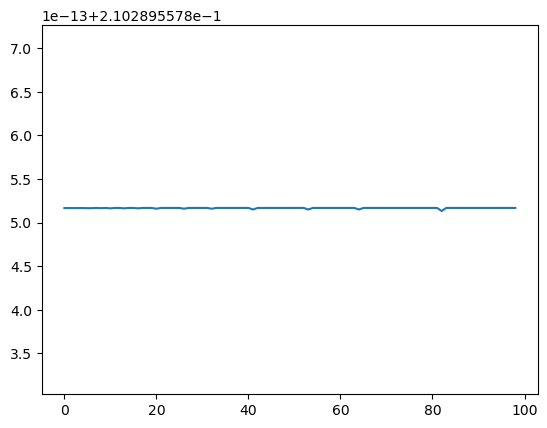

In [168]:
plt.plot(np.diff(merged[:100]))

## Notes on the incorrect padding in the code 

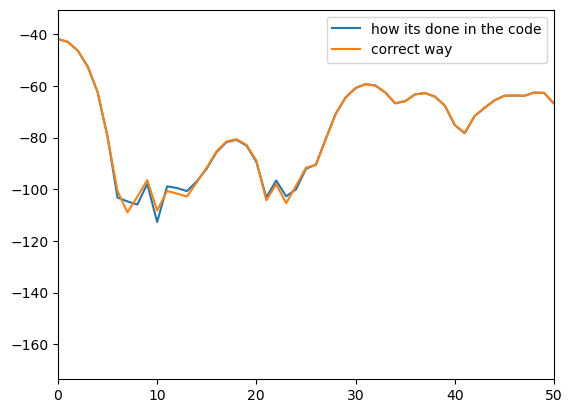

In [44]:

def dB(S):
    return 20*np.log10(np.abs(S))
chirp = ds.chirp.squeeze()    # .squeeze() removes the singleton dimensions

s_one_chirp = chirp.isel(chirp_num=0).values.squeeze()  # again, .squeeze() removes unnecessary singleton dimensions)
Nt = rdei(len(s_one_chirp))
Nfft = rdi(Nt*pad_factor)
winchirp = np.multiply(s_one_chirp[0:Nt], np.blackman(Nt))

padchirp1 = np.zeros(Nfft)
padchirp1[0:math.floor(Nt/2)-1] = winchirp[math.floor(Nt/2):-1]
padchirp1[-math.floor(Nt/2):-1] = winchirp[0:math.floor(Nt/2)-1]

padchirp2 = np.zeros(Nfft)
padchirp2[0:math.floor(Nt/2)] = winchirp[math.floor(Nt/2):]
padchirp2[-math.floor(Nt/2):] = winchirp[0:math.floor(Nt/2)]

profile_padded1 = np.fft.fft(padchirp1)/Nfft * np.sqrt(2*pad_factor) 
profile_padded2 = np.fft.fft(padchirp2)/Nfft * np.sqrt(2*pad_factor) 
bin2m1 = c/(2*pad_factor*np.sqrt(ep)*K)
r_padded1 = np.arange(Nfft) * bin2m1

plt.plot(dB(profile_padded1), marker = '', label = 'how its done in the code')
plt.plot(dB(profile_padded2), marker = '', label = 'correct way')
plt.xlim([0, 50])
plt.legend()
